# Kitten states via photon subtraction

Author: Nicolás Quesada 

In this tutorial we study how to prepare a cat state with a small amplitude (i.e. a kitten state) by doing photon subtraction.
This idea goes back to the following paper:
"Generating Schrödinger-cat-like states by means of conditional measurements on a beam splitter" [Phys. Rev. A *55*, 3184, (1997)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.55.3184) by M. Dakna, T. Anhut, T. Opatrný, L. Knöll, and D.-G. Welsch


In [ ]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
from thewalrus.quantum import state_vector, density_matrix
from qutip import wigner, Qobj, wigner_cmap

## Ideal preparation

Here we setup some basic parameters, like the value of the photon-number-resolving detectors we will use to herald and the amount of squeezing to use. We pick the squeezing parameter to be $r = 1.0$. We also fix the beam-splitter angle to have a high transmissivity (i.e. $\theta \ll 1$)

In [2]:
n = 1
r = 1.0
theta = np.arccos(np.sqrt(0.97))
theta

0.17408301063648038

Now we setup a 2-mode quantum circuit in strawberryfields and obtain the covariance matrix and vector of means of the Gaussian state

In [3]:
nmodes = 2
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")
with prog.context as q:
    Sgate(r)|q[1]
    BSgate(theta,0.0)|q
state = eng.run(prog).state
mu = state.means()
cov = state.cov()

We can now inspect the covariance matrix and vector of means. Note that the vector of means is zero since we did not use any displacement gates in the circuit above.

In [4]:
print(np.round(mu,10))
print(np.round(cov,10))

[0. 0. 0. 0.]
[[ 0.97406006  0.14750075  0.          0.        ]
 [ 0.14750075  0.16127522  0.          0.        ]
 [ 0.          0.          1.19167168 -1.08989133]
 [ 0.          0.         -1.08989133  7.19738442]]


We now use the walrus to obtain the Fock representation of the photon-subtracted state when mode 0 is heralded in the value $n=1$ in the variable `psi`. We also calculate the probability of success in heralding in the variable `p_psi`

In [5]:
cutoff = 20
psi = state_vector(mu, cov, post_select={0:n}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi/p_psi
print("The probability of successful heralding is ", np.round(p_psi**2,5))

The probability of successful heralding is  0.03551


We now plot the photon-number distribution of the Heralded state. Note that the state only has odd photon components

Text(0, 0.5, '$p_i$')

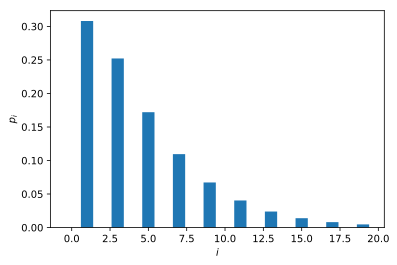

In [6]:
plt.bar(np.arange(cutoff),np.abs(psi)**2)
plt.xlabel("$i$")
plt.ylabel(r"$p_i$")

We can now plot the Wigner function of the heralded state

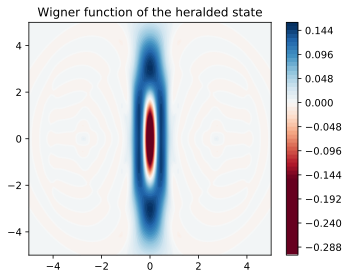

In [7]:
grid = 100
xvec = np.linspace(-5,5,grid)
Wp = wigner(Qobj(psi), xvec, xvec)
wmap = wigner_cmap(Wp)
sc1 = np.max(Wp)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
plt1 = axes.contourf(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.set_title("Wigner function of the heralded state");
cb1 = fig.colorbar(plt1, ax=axes)
fig.tight_layout()
plt.show()

and a cut of the Wigner function along $p=0$

Text(0.5, 0, 'p')

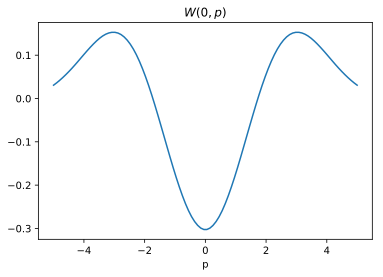

In [8]:
plt.plot(xvec, Wp[:,grid//2])
plt.title(r"$W(0,p)$")
plt.xlabel(r"p")

## Adding Loss

We can now study what happens when loss in the heralding arm is increased. We will add loss in the heralding arm by varying the efficiency of the detector which is parametrized by a transmission $\eta$ ranging from $\eta = 50\%$ to $\eta = 100\%$ (ideal operation).

In [9]:
eta_vals = np.arange(1.,0.45,-0.05)
fidelities = np.zeros_like(eta_vals)
success_p = np.zeros_like(eta_vals)
nmodes = 2
for i,eta in enumerate(eta_vals):
    prog = sf.Program(nmodes)
    eng = sf.Engine("gaussian")
    with prog.context as q:
        Sgate(r)|q[1]
        BSgate(theta,0.0)|q
        LossChannel(eta)|q[0]
    state = eng.run(prog).state
    mu = state.means()
    cov = state.cov()
    rho = density_matrix(mu, cov, post_select={0:n}, normalize=False, cutoff=cutoff)
    success_p[i] = np.real_if_close(np.trace(rho))
    fidelities[i] = np.real_if_close(psi.conj() @ rho @ psi/success_p[i])

We now plot the probability of success of the Heralding scheme as a function of the transmission

Text(0, 0.5, 'Success probability')

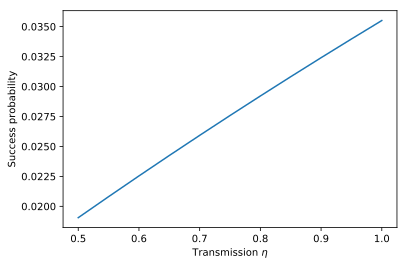

In [10]:
plt.plot(eta_vals, success_p)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Success probability")

and similarly study the fidelity of the heralded state with respect to the ideal (lossless) state

Text(0, 0.5, 'Fidelity with ideal state')

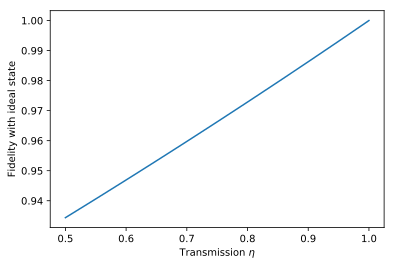

In [11]:
plt.plot(eta_vals, fidelities)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Fidelity with ideal state")

We can also look at the photon number distribution of the nonideal state. 

Text(0, 0.5, '$p_i$')

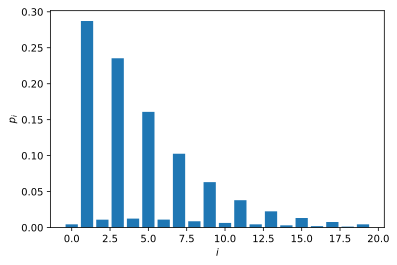

In [12]:
plt.bar(np.arange(cutoff),np.real_if_close(np.diag(rho/np.trace(rho))))
plt.xlabel(r"$i$")
plt.ylabel(r"$p_i$")

Now we plot the Wigner function of the heralded state for $\eta = 50\%$

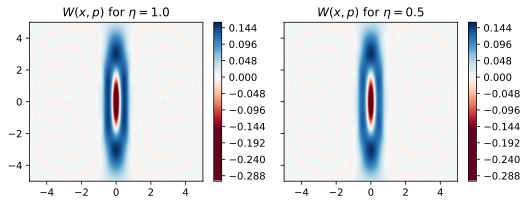

In [13]:
sc1 = np.max(Wp)
W = wigner(Qobj(rho/np.trace(rho)), xvec, xvec)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3),sharey=True)
axes[0].contourf(xvec, xvec, Wp, 60,cmap=cm.RdBu, norm=nrm)
axes[0].contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes[0].set_title(r"$W(x,p)$ for $\eta = 1.0$");
cb1 = fig.colorbar(plt1, ax=axes[0])
plt2 = axes[1].contourf(xvec, xvec, W ,60, cmap=cm.RdBu, norm=nrm)  
plt2 = axes[1].contour(xvec, xvec, W ,60, cmap=cm.RdBu, norm=nrm)  
axes[1].set_title(r"$W(x,p)$ for $\eta = 0.5$");
cb2 = fig.colorbar(plt1, ax=axes[1])
fig.tight_layout()
plt.show()

and also a cut of the Wigner function along $x=0$

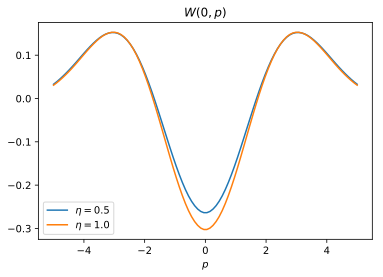

In [14]:
plt.plot(xvec, W[:,grid//2], label=r"$\eta=0.5$")
plt.plot(xvec, Wp[:,grid//2], label=r"$\eta=1.0$")
plt.title(r"$W(0,p)$")
plt.xlabel(r"$p$")
plt.legend()

Note that unlike for the case of a Heralded Fock state, here loss in the heralding arms has no effect. For a simple explanation of why this is the case cf. Sec. IV.B. of "Simulating realistic non-Gaussian state preparation" [Phys. Rev. A *100*, 022341 (2019)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.022341)
by N. Quesada, L. G. Helt, J. Izaac, J. M. Arrazola, R. Shahrokhshahi, C. R. Myers, and K. K. Sabapathy

In [15]:
%reload_ext version_information
%version_information qutip, strawberryfields, thewalrus

Software versions
Python 3.6.8 64bit [GCC 7.3.0]
IPython 7.2.0
OS Linux 4.15.0 58 generic x86_64 with debian stretch sid
qutip 4.3.1
strawberryfields 0.12.0-dev
thewalrus 0.8.0-dev
Tue Sep 17 17:46:05 2019 EDT